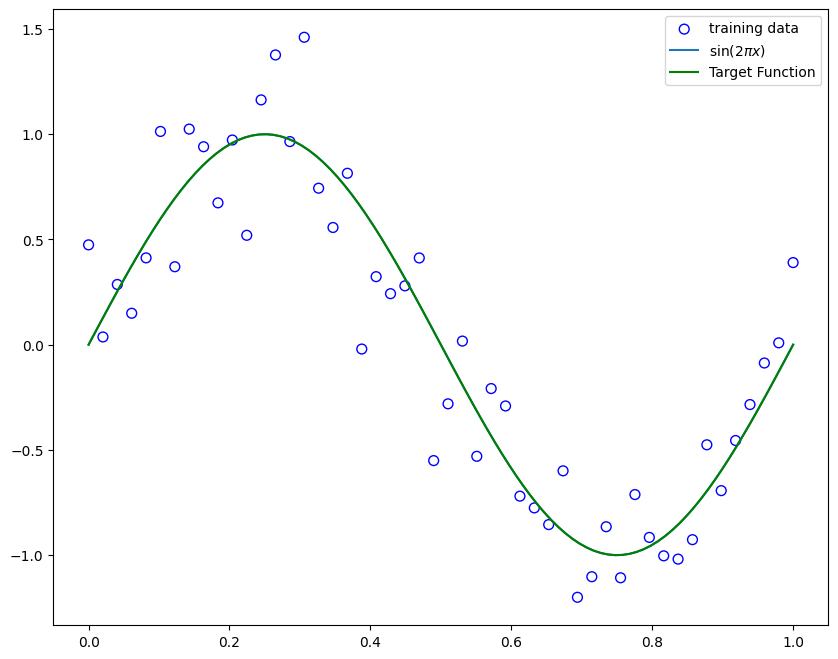

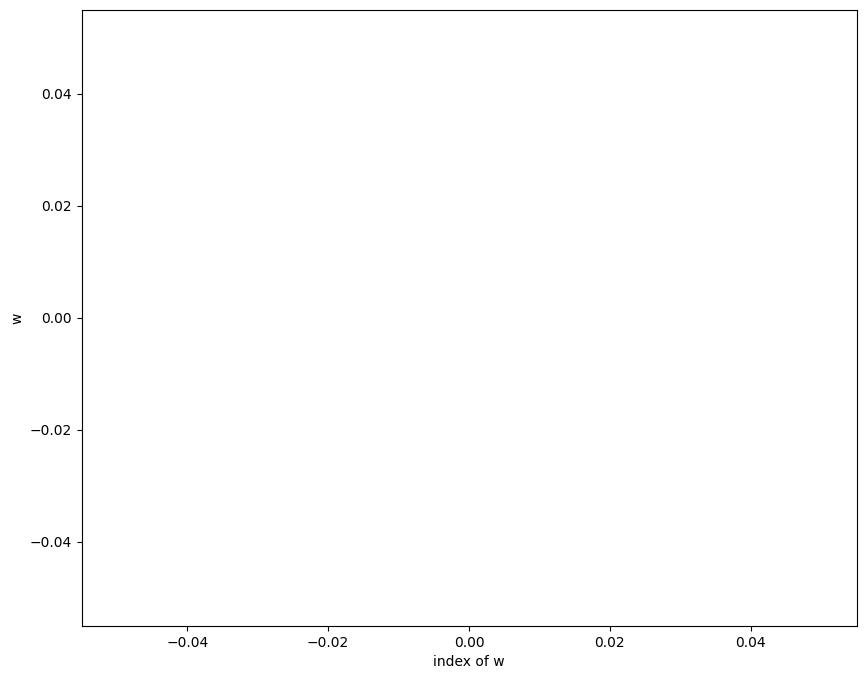

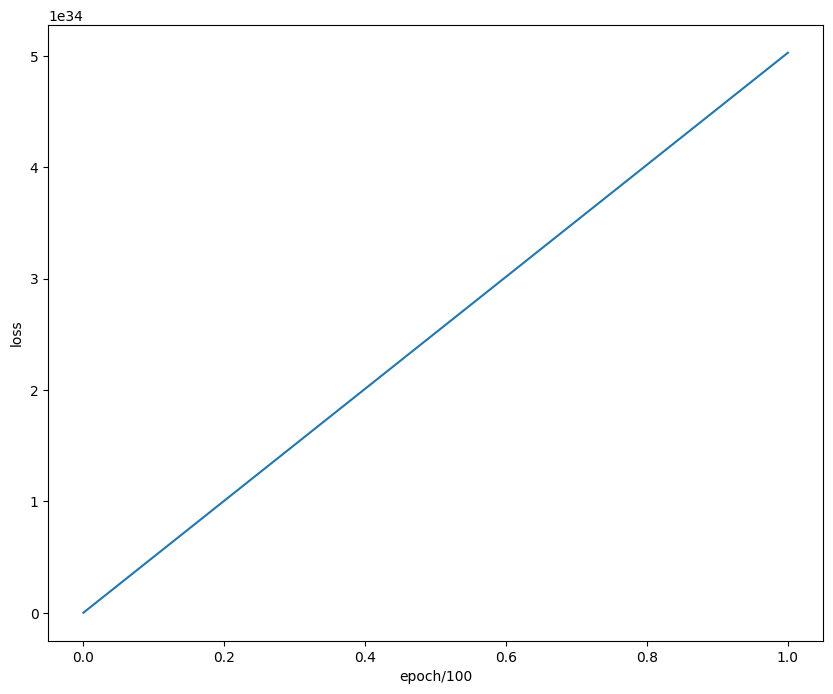

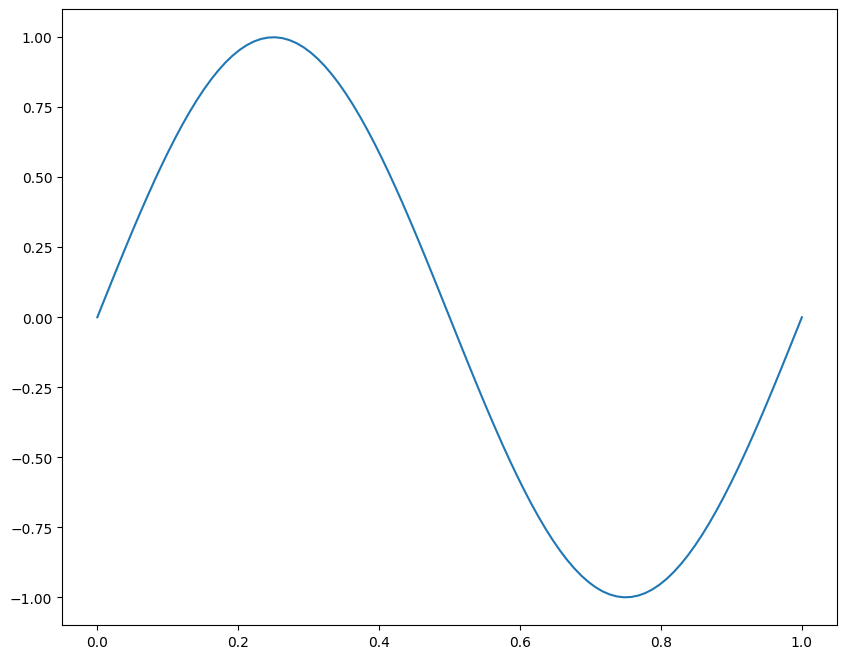

In [486]:
import torch
import matplotlib.pyplot as plt

def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = torch.linspace(domain[0], domain[1], sample_size)
    x = x[torch.randperm(x.shape[0])]
    y = func(x) + torch.zeros(x.shape[0]).normal_(std=std)
    return x, y
def sinusoidal(x):
    return torch.sin(2 * torch.pi * x)
def g(w,x):
    # basis_func is x^0, x^1, x^2, ..., x^M
    basis_func = torch.full((w.size()), x) ** torch.arange(0,w.size(dim=0))
    return torch.dot(w, basis_func)

#generate training and test data
x_train, y_train = create_toy_data(sinusoidal, 50, 0.25)
x_test = torch.linspace(0, 1, 100)
y_test = sinusoidal(x_test)
plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y_test, "-g", label="Target Function")
plt.legend()
# Set order of the polynomial to 4
M = 4
# Initialize weights
w = torch.zeros(M)
prev_velocity = torch.zeros(M)
# All hyper parameters were found manually since looping through various values for all 3 of them would take too long
# Learning rate hyperparameter(depends on iterations and overstepping)
learning_rate = 0.4
#lambda hyperparameter(not so important for a low order polynomial)
lambdaHyperpameter = 0.00001
# Mini-batch size hyperparameter(smaller mini-batch is faster but more noisy)
# Change mini-batch size to 2-4 for much faster run but extremely noisy loss
m = 16
# Momentum hyperparameter
momentum_param = 0.9
iterations = 20000
losses = torch.zeros(int(iterations/100))
for epoch in range(iterations):
    # Pick random training data
    miniBatch = torch.randint(x_train.size(dim=0),(m,))
    loss = 0
    gradient = torch.zeros(M)
    # Calculate loss
    # Equation shown below in markdown
    for i in miniBatch:
        loss += pow(g(w,x_train[i])-y_train[i], 2)
    loss = loss/m + lambdaHyperpameter*torch.sum(torch.pow(w,2))
    if (epoch%100 == 0):
        losses[int(epoch/100)] = loss
    # Calculate gradient
    # Equation shown below in markdown
    for j in range(M):
        for i in miniBatch:
            gradient[j] += (g(w,x_train[i])-y_train[i])*pow(x_train[i],j)
        gradient[j] = gradient[j] * (2/m) + 2*lambdaHyperpameter*w[j]
    # Update weights
    velocity =  gradient + momentum_param*prev_velocity
    prev_velocity = gradient
    w = w - learning_rate*velocity
    #print("epoch: " + str(epoch) + "   loss: " + str(loss) + "   gradient: " + str(gradient) + "   w: " + str(w) + "\n")
# Plot weights
plt.figure(figsize=[10,8])
plt.plot(w)
plt.xlabel("index of w")
plt.ylabel("w")
# Plot loss vs epoch
plt.figure(figsize=[10,8])
plt.plot(losses)
plt.xlabel("epoch/100")
plt.ylabel("loss")
# Plot final hypothesis
plt.figure(figsize=[10,8])
y_pred = torch.zeros(x_test.size(dim=0))
for i in range(x_test.size(dim=0)):
    y_pred[i] = g(w,x_test[i])
plt.scatter(x_test, y_pred, label="Final hypothesis")
plt.plot(x_test, y_test, label="Target Function")
plt.show()

Hyperparameters:
  * $\eta$: learning_rate = 0.4
  * $\lambda$: lambdaHyperparameter = 0.00001
  * mini-batch size: m = 16
$$
L(w)=\frac{1}{m}\sum_{i=1}^{m}\{(g(w,x_i)-y_i)\}^2+\lambda||w||^2
$$
$$
\frac{\partial L(w)}{\partial w_j} = \frac{2}{m}\sum_{i=1}^{m}\{(g(w,x_i)-y_i)x_i{^j}\}+2{\lambda}w_j
$$

In [36]:
import pandas as pd
orig_data = pd.read_csv("./train/train.csv", skiprows = lambda i: i%1000 != 0)

In [452]:
import math
# Make a copy of the data so that I can test preprocessing without altering the original dataframe
data = orig_data.copy(deep=False)
# Replace each category with its frequency in the dataset
def count_encode(data, columns):
    df = data.copy()
    for column in columns:
        df[column] = df[column].map(df[column].value_counts().to_dict())
    return df
data = count_encode(data, ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model'])
# The hour is in format YYMMDDHH so the last 2 digits are the hour of the day
data['hour'] = abs(data['hour']%100-12.5)
data['C20'] = (data['C20'] == -1).astype('int32')
#x = data[['hour','C1','banner_pos','device_type','device_conn_type','C14','C15','C16','C17','C18','C19','C20','C21']]
x = data.drop(columns=['click', 'id'])
y = data['click']
def standardize(data):
    df = data.copy()
    for column in df.columns:
        df[column] = (df[column]-df[column].mean())/df[column].std()
    return df
x = standardize(x)
x_train = x.iloc[x.index % 5 != 0]
x_test = x.iloc[x.index % 5 == 0]
y_train = y.iloc[y.index % 5 != 0]
y_test = y.iloc[y.index % 5 == 0]
x_train = torch.tensor(x_train.values)
y_train = torch.tensor(y_train.values)
x_test = torch.tensor(x_test.values)
y_test = torch.tensor(y_test.values)
positive = 0
negative = 0
for test in y_test:
    if(test == 1):
        positive += 1
    else:
        negative += 1
print(positive, negative, float(positive)/(positive+negative))

1412 6674 0.17462280484788523


min loss: tensor(0.9354)
tensor([0.5432, 0.1566, 0.8345,  ..., 0.8272, 0.3113, 0.0227])
tp: 281	fp: 1348	tn: 12000	fn: 2543


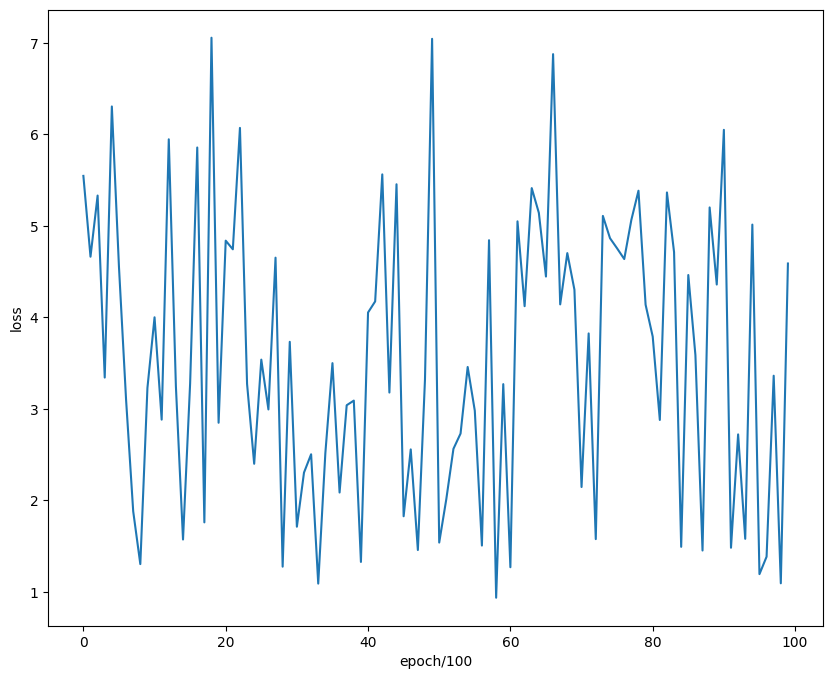

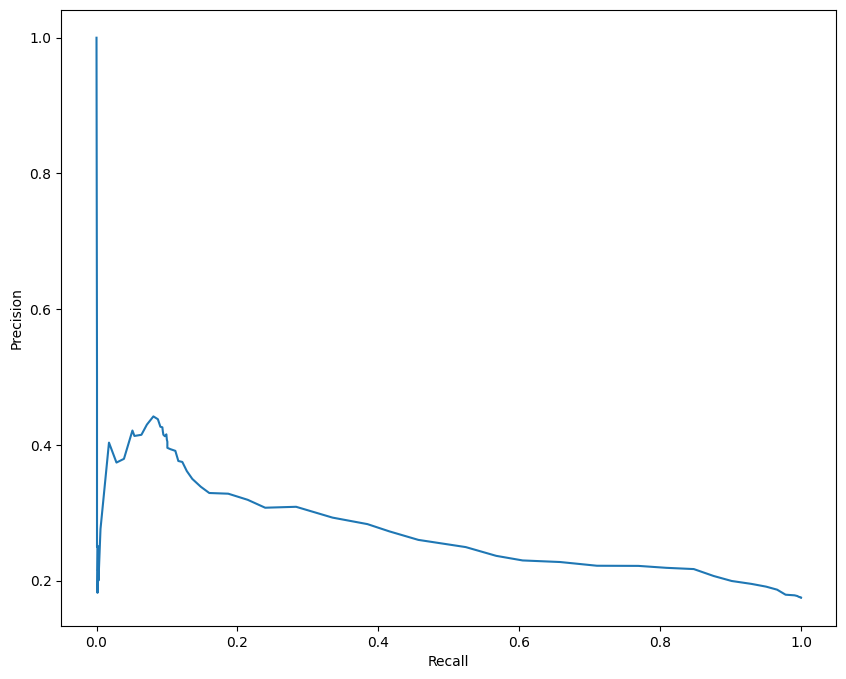

In [450]:
def logistic(x):
    return 1/(1+math.pow(math.e, -x))
w = torch.zeros(x_train.size(dim=1))
# A large learning rate causes large weights so the logistic function may round to 0 or 1, causing math.log to become infinity
learning_rate = 0.1
#lambda hyperparameter
lambdaHyperpameter = 0.0001
# If mini-batch is far too small(e.g. 1) we take the log loss of only 1 prediction which does not represent the dataset's overall loss well
m = 8
# Run for 20000 iterations
iterations = 10000
losses = torch.zeros(int(iterations/100))
best_weights = torch.zeros(x_train.size(dim=1))
min_loss = float('inf')
bias = 0
prev_velocity = torch.zeros(w.size(dim=0))
momentum_param = 0.9
decay_rate = 0.0001
for epoch in range(iterations):
    miniBatch = torch.randint(x_train.size(dim=0),(m,))
    loss = 0
    gradient = torch.zeros(w.size(dim=0)).float()
    # Calculate loss
    # Equation shown below in markdown
    if (epoch%100 == 0):
        for i in miniBatch:
            yHat = logistic(torch.dot(w, x_train[i].float())+bias)
            loss -= y_train[i]*math.log(yHat)+(1-y_train[i])*math.log(1-yHat)
            #loss -= y_train[i]*torch.sum(torch.dot(w, x_train[i].float())) + math.log(1+math.pow(math.e,torch.sum(torch.dot(w, x_train[i].float()))))
        #loss = loss/m + lambdaHyperpameter*torch.sum(torch.pow(w,2))
        losses[int(epoch/100)] = loss
        if(loss<min_loss):
            min_loss = loss
            best_weights = w
    # Calculate gradient
    # Equation shown below in markdown
    for j in range(w.size(dim=0)):
        for i in miniBatch:
            gradient[j] += (logistic(torch.dot(w, x_train[i].float())+bias)-y_train[i])*x_train[i][j] + 2*lambdaHyperpameter*w[j]
    gradient =  gradient + momentum_param*prev_velocity
    prev_velocity = gradient
    # Update weights
    db = 0
    for i in miniBatch:
        db += logistic(torch.dot(w, x_train[i].float())+bias)-y_train[i]
    db /= m
    learning_rate *= math.pow(math.e, -decay_rate*epoch)
    w -= learning_rate*gradient
    bias -= learning_rate*db
    #if(epoch%100==0):
    #    print("epoch: " + str(epoch) + "   loss: " + str(loss) + "   gradient: " + str(gradient) + "   w: " + str(w) + "\n")
w = best_weights
print("min loss: " + str(min_loss))
# Plot loss vs epoch
plt.figure(figsize=[10,8])
plt.plot(losses)
plt.xlabel("epoch/100")
plt.ylabel("loss")
y_pred = torch.zeros(x_test.size(dim=0))
for i in range(x_test.size(dim=0)):
    y_pred[i] = logistic(torch.dot(w, x_test[i].float())+bias)
thresholds = torch.linspace(0,1,100)
precision = torch.zeros(thresholds.size(dim=0))
recall = torch.zeros(thresholds.size(dim=0))
index = 0
for threshold in thresholds:
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(x_test.size(dim=0)):
        if(y_pred[i] >= threshold):
            if(y_test[i] == 1):
                tp += 1
            else:
                fp += 1
        else:
            if(y_test[i] == 0):
                tn += 1
            else:
                fn += 1
    if(fp == 0):
        precision[index] = 1
    else:
        precision[index] = float(tp)/(tp+fp)
    if(fn == 0):
        recall[index] = 1
    else:
        recall[index] = float(tp)/(tp+fn)
    index += 1
plt.figure(figsize=[10,8])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall,precision)
y_pred = torch.rand(x_test.size(dim=0))
print(y_pred)
for i in range(x_test.size(dim=0)):
    if(y_pred[i] >= 0.8):
        if(y_test[i] == 1):
            tp += 1
        else:
            fp += 1
    else:
        if(y_test[i] == 0):
            tn += 1
        else:
            fn += 1
print(f"tp: {tp}\tfp: {fp}\ttn: {tn}\tfn: {fn}")